In [17]:
import numpy as np
import json
import torch
import torch_geometric
import torch.nn as nn
import torch_geometric.nn as gnn
from pathlib import Path
from sklearn.metrics import accuracy_score
from sentence_transformers import SentenceTransformer
from numpy.linalg import norm
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def flatten(list_of_list):
    return [item for sublist in list_of_list for item in sublist]

training_set = ['ES2002']
# training_set = ['ES2002', 'ES2005', 'ES2006', 'ES2007', 'ES2008', 'ES2009', 'ES2010', 'ES2012', 'ES2013', 'ES2015', 'ES2016', 'IS1000', 'IS1001', 'IS1002', 'IS1003', 'IS1004', 'IS1005', 'IS1006', 'IS1007', 'TS3005', 'TS3008', 'TS3009', 'TS3010', 'TS3011', 'TS3012']
training_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in training_set])
training_set.remove('ES2002a')
# training_set.remove('IS1002a')
# training_set.remove('IS1005d')
# training_set.remove('TS3012c')

test_set = ['ES2003']
# test_set = ['ES2003', 'ES2004', 'ES2011', 'ES2014', 'IS1008', 'IS1009', 'TS3003', 'TS3004', 'TS3006', 'TS3007']
test_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in test_set])

In [3]:
path_to_training = Path("training")
path_to_test = Path("test")

In [4]:
with open("training_labels.json", "r") as file:
    training_labels = json.load(file)

Bert_training = []
E_training = [] # Contains edges of the graphs, with associated labels
y_training = []

n_examples = len(training_set)

for train_id in training_set:
    current_bert = []
    with open(path_to_training / f"{train_id}.json", "r") as file:
        transcription = json.load(file)

    for utterance in transcription:
        current_bert.append(utterance["speaker"] + ": " + utterance["text"])
    y_training.append(training_labels[train_id])
    Bert_training.append(current_bert)

    with open(path_to_training / f"{train_id}.txt", "r") as file:
        lines = [line.rstrip() for line in file]
        edges = [line.split(" ") for line in lines]
        edges = [[edge[1], int(edge[0]), int(edge[2])] for edge in edges]
        E_training.append(edges)
edge_tensor = [torch.LongTensor([[l[1], l[2]] for l in edge_set] + [[l[2], l[1]] for l in edge_set]).T for edge_set in E_training]
edge_index = [np.array([[l[1], l[2]] for l in edge_set] + [[l[2], l[1]] for l in edge_set]) for edge_set in E_training]
adjacency_lists = [[[l[1], l[2]] for l in edge_set] for edge_set in E_training]

In [5]:
bert = SentenceTransformer('all-MiniLM-L6-v2')

Embeddings_training = [bert.encode(el, show_progress_bar=False) for el in Bert_training]

In [139]:
# Calculating useful node features

graphs = [nx.Graph(l) for l in adjacency_lists]
centralities = [nx.betweenness_centrality(G) for G in graphs]
node_features = [torch.tensor([[graphs[a].degree(i), centralities[a][i]] for i in range(graphs[a].number_of_nodes())]) for a in range(len(graphs))]

In [7]:
# Calculating useful edge features
edge_cosine_sim = [np.array([Embeddings_training[i][edge[0]] @ Embeddings_training[i][edge[1]] / (norm(Embeddings_training[i][edge[0]]) * norm(Embeddings_training[i][edge[1]])) for edge in edge_index[i]]) for i in range(n_examples)]
edge_distance = [np.array([norm(Embeddings_training[i][edge[0]] - Embeddings_training[i][edge[1]]) for edge in edge_index[i]]) for i in range(n_examples)]
edge_label = [np.array([l[0] for l in edge_set]) for edge_set in E_training]

edge_attr = [torch.tensor(np.column_stack([edge_cosine_sim[i], edge_distance[i]])).T for i in range(n_examples)]

In [8]:
data = [Data(x=node_features[i], edge_index=edge_tensor[i], edge_attr=edge_attr[i]) for i in range(n_examples)]

In [230]:


model = gnn.Sequential('x, edge_index, edge_attr,', [
    (gnn.ResGatedGraphConv(2, 30, edge_dim = 2), 'x, edge_index, edge_attr -> x'),
    nn.ReLU(),
    (gnn.ResGatedGraphConv(30, 30, edge_dim = 2), 'x, edge_index, edge_attr -> x'),
    nn.ReLU(),
    (gnn.GCNConv(30, 30), 'x, edge_index -> x'),
    nn.ReLU(),
    (gnn.GCNConv(30, 30), 'x, edge_index -> x'),
    nn.ReLU(),
    gnn.Linear(30, 1),
    nn.Sigmoid()
])

pp=0
for p in list(model.parameters()):
    a=1
    for s in list(p.size()):
        a = a*s
    pp += a
print(pp)

6331


tensor(168.)
tensor(0.5127, grad_fn=<MeanBackward0>)


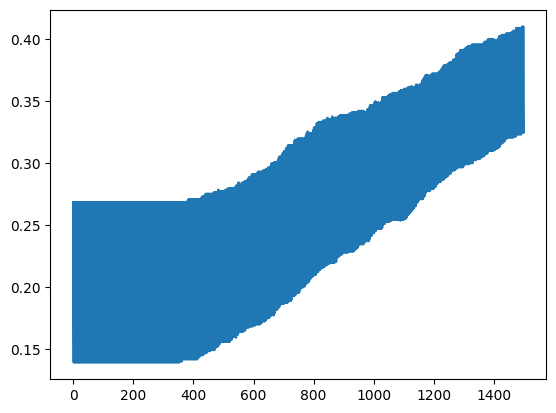

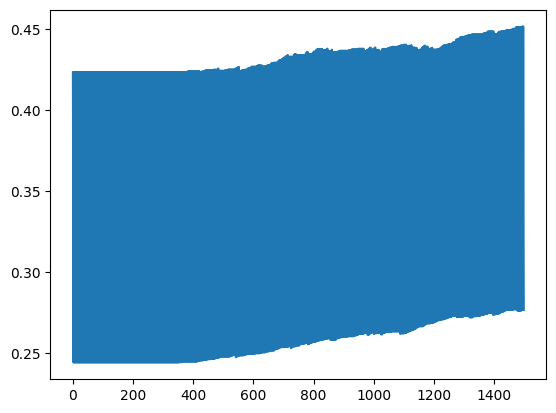



La précision est de :
0.3247721623860812




In [231]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)


optimizer = torch.optim.SGD(model.parameters(), lr=10) #actually SGD is just GD in this case

losses = []
tr_acc = []
tr_f1 = []
for epoch in range(500):
    for i in range(3):
        dataset = data[i].to(device)
        Y_train = torch.FloatTensor(y_training[i]).to(device).unsqueeze(1)
        output = model(dataset.x, dataset.edge_index, dataset.edge_attr.T)
        weights = Y_train * (Y_train.shape[0] - Y_train.sum()) + (-Y_train + 1) * Y_train.sum()
        loss_function = nn.BCELoss(weight = weights/(weights.sum())) # Weighing positive examples more to favorise F1-score
        loss = loss_function(output, Y_train)
        optimizer.zero_grad() #required since pytorch accumulates the gradients
        loss.backward() #backpropagation step
        optimizer.step() #update the parameters

        losses.append(loss.data)
        guesses = np.round(output.detach().numpy())
        reality = Y_train.detach().numpy()
        tr_acc.append(accuracy_score(reality, guesses))
        p = np.sum(guesses * reality) / np.sum(guesses)
        r = np.sum(guesses * reality) / np.sum(reality)
        tr_f1.append(2*p*r/(p+r))

print(Y_train.sum())
print(output.mean())
plt.figure()
plt.plot(tr_acc)
plt.show()
plt.figure()
plt.plot(tr_f1)
plt.show()
print("\n\nLa précision est de :")
print(tr_acc[-1])
print("\n")